# Example of Hierarchical Models with MCMC

Converted the `pyro` example on '[analyzing baseball stats with MCMC](https://pyro.ai/examples/baseball.html)' in `numpyro`.

> Example has been adapted from [1]. It demonstrates how to do Bayesian inference using NUTS (or, HMC) in Pyro, and use of some common inference utilities.
>
> As in the Stan tutorial, this uses the small baseball dataset of Efron and Morris [2] to estimate players' batting average which is the fraction of times a player got a base hit out of the number of times they went up at bat.
>
> The dataset separates the initial 45 at-bats statistics from the remaining season. We use the hits data from the initial 45 at-bats to estimate the batting average for each player. We then use the remaining season's data to validate the predictions from our models.
>
> Three models are evaluated:
> - Complete pooling model: The success probability of scoring a hit is shared amongst all players.
> - No pooling model: Each individual player's success probability is distinct and there is no data sharing amongst players.
> - Partial pooling model: A hierarchical model with partial data sharing.
>
>
> We recommend Radford Neal's tutorial on HMC ([3]) to users who would like to get a more comprehensive understanding of HMC and its variants, and to [4] for details on the No U-Turn Sampler, which provides an efficient and automated way (i.e. limited hyper-parameters) of running HMC on different problems.
>
> * [1] Carpenter B. (2016), ["Hierarchical Partial Pooling for Repeated Binary Trials"](http://mc-stan.org/users/documentation/case-studies/pool-binary-trials.html).
> * [2] Efron B., Morris C. (1975), "Data analysis using Stein's estimator and its generalizations", J. Amer. Statist. Assoc., 70, 311-319.
> * [3] Neal, R. (2012), "MCMC using Hamiltonian Dynamics", ([https://arxiv.org/pdf/1206.1901.pdf])
> * [4] Hoffman, M. D. and Gelman, A. (2014), "The No-U-turn sampler: Adaptively setting path lengths in Hamiltonian Monte Carlo", ([https://arxiv.org/abs/1111.4246])

In [1]:
# Modeling
import numpyro
import numpyro.distributions as dist
from jax import random
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS, Predictive

# Diagnostics and Viz
import arviz as az
from numpyro.diagnostics import hpdi

import pandas as pd

In [2]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/EfronMorrisBB.txt"

In [3]:
def train_test_split(pd_dataframe):
    """
    Training data - 45 initial at-bats and hits for each player.
    Validation data - Full season at-bats and hits for each player.
    """
    train_data = pd_dataframe[["At-Bats", "Hits"]].values
    test_data = pd_dataframe[["SeasonAt-Bats", "SeasonHits"]].values
    first_name = pd_dataframe["FirstName"].values
    last_name = pd_dataframe["LastName"].values
    player_names = [
        " ".join([first, last]) for first, last in zip(first_name, last_name)
    ]
    return train_data, test_data, player_names

def run_inference(model, at_bats, hits):
    # Run the inference
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=100, num_samples=200, num_chains=4)
    mcmc.run(random.PRNGKey(1), at_bats, hits)
    return mcmc

In [4]:
baseball_dataset = pd.read_csv(DATA_URL, sep="\t")
train, _, player_names = train_test_split(baseball_dataset)
at_bats, hits = train[:, 0], train[:, 1]
display(baseball_dataset.head())
print(baseball_dataset.shape)

,FirstName,LastName,At-Bats,Hits,BattingAverage,RemainingAt-Bats,RemainingAverage,SeasonAt-Bats,SeasonHits,SeasonAverage
0,Roberto,Clemente,45,18,0.400,367,0.3460,412,145,0.352
1,Frank,Robinson,45,17,0.378,426,0.2981,471,144,0.306
2,Frank,Howard,45,16,0.356,521,0.2764,566,160,0.283
3,Jay,Johnstone,45,15,0.333,275,0.2218,320,76,0.238
4,Ken,Berry,45,14,0.311,418,0.2727,463,128,0.276


(18, 10)


## Modeling

### Fully Pooled Model

$$
K_i \sim \operatorname{Binomial}(\phi)
$$

Number of hits in $K$ at bats for each player has a Binomial distribution with a common probability of success, $\phi$.


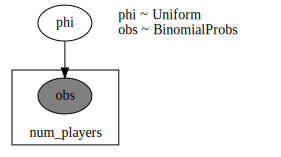

In [5]:
def fully_pooled(at_bats, hits):
    r"""
    Number of hits in $K$ at bats for each player has a Binomial
    distribution with a common probability of success, $\phi$.

    Parameters
    ----------
    at_bats: Number of at bats for each player.
    hits: Number of hits for the given at bats.
    
    Returns
    -------
    Number of hits predicted by the model.
    """
    phi_prior = dist.Uniform(0, 1)
    phi = numpyro.sample("phi", phi_prior)
    num_players = at_bats.shape[0]
    with numpyro.plate("num_players", num_players):
        return numpyro.sample("obs", dist.Binomial(at_bats, phi), obs=hits)
    
numpyro.render_model(fully_pooled, (at_bats, hits), render_distributions=True)

In [6]:
model = fully_pooled

# Run the inference
mcmc = run_inference(model, at_bats, hits)
mcmc.print_summary()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/tmp/ipykernel_155878/457514835.py:18: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=100, num_samples=200, num_chains=4)
sample: 100%|██████████| 300/300 [00:00<00:00, 7004.63it/s, 3 steps of size 1.28e+00. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       phi      0.27      0.02      0.27      0.24      0.30    305.40      1.01

Number of divergences: 0


### Unpooled Model

$$
K_i \sim \operatorname{Binomial}(\phi_i)
$$

Number of hits in $K$ at bats for each player has a Binomial distribution with independent probability of success, $\phi_i$.

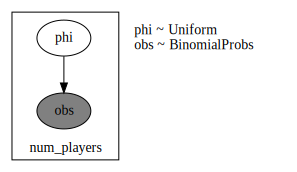

In [7]:
def not_pooled(at_bats, hits):
    r"""
    Number of hits in $K$ at bats for each player has a Binomial
    distribution with independent probability of success, $\phi_i$.

    Parameters
    ----------
    at_bats: Number of at bats for each player.
    hits: Number of hits for the given at bats.
    
    Returns
    -------
    Number of hits predicted by the model.
    """
    num_players = at_bats.shape[0]
    with numpyro.plate("num_players", num_players):
        phi_prior = dist.Uniform(jnp.zeros(num_players), jnp.ones(num_players))
        phi = numpyro.sample("phi", phi_prior)
        return numpyro.sample("obs", dist.Binomial(at_bats, phi), obs=hits)

numpyro.render_model(not_pooled, (at_bats, hits), render_distributions=True)

In [8]:
model = not_pooled

# Run the inference
mcmc = run_inference(model, at_bats, hits)
mcmc.print_summary()

/tmp/ipykernel_155878/457514835.py:18: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=100, num_samples=200, num_chains=4)


sample: 100%|██████████| 300/300 [00:00<00:00, 8160.23it/s, 7 steps of size 7.72e-01. acc. prob=0.82]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    phi[0]      0.40      0.07      0.40      0.29      0.51   1092.52      1.00
    phi[1]      0.38      0.07      0.38      0.26      0.49   1633.13      1.00
    phi[2]      0.36      0.07      0.36      0.24      0.46   1564.79      1.00
    phi[3]      0.34      0.07      0.34      0.23      0.44   1399.76      1.00
    phi[4]      0.31      0.06      0.31      0.22      0.42   1715.87      1.00
    phi[5]      0.32      0.07      0.31      0.21      0.44   1686.94      1.00
    phi[6]      0.30      0.07      0.29      0.19      0.42   2197.84      1.00
    phi[7]      0.27      0.07      0.27      0.16      0.38   1502.85      1.00
    phi[8]      0.25      0.06      0.25      0.15      0.35   1889.72      1.00
    phi[9]      0.25      0.06      0.25      0.16      0.36   2428.88      1.00
   phi[10]      0.24      0.06      0.23      0.14      0.33   1553.43      1.00
   phi[11]      0.23      0

### Partial Pooling

$$
\begin{aligned}
K_i &\sim \operatorname{Binomial}(\phi_i) \\
\phi_i &\sim \operatorname{Uniform}(c_1, c_2) \\
c_1 &= m * \kappa\\
c_2 &= (1-m) * \kappa\\
\kappa &\sim \operatorname{Pareto}(1, 1.5)
\end{aligned}
$$

Number of hits has a Binomial distribution with independent probability of success, $\phi_i$. 

Each $\phi_i$ follows a Beta distribution with concentration parameters $c_1$ and $c_2$, where:
* $c_1 = m * \kappa$
* $c_2 = (1 - m) * \kappa$
* $m \sim \text{Uniform}(0, 1)$
* and $\kappa \sim \text{Pareto}(1, 1.5)$.

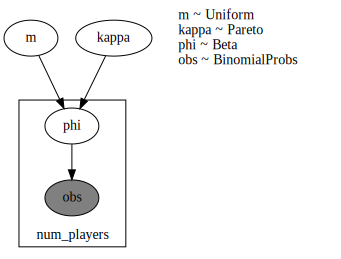

In [9]:
def partially_pooled(at_bats, hits):
    r"""
    Number of hits has a Binomial distribution with independent
    probability of success, $\phi_i$. Each $\phi_i$ follows a Beta
    distribution with concentration parameters $c_1$ and $c_2$, where
    $c_1 = m * kappa$, $c_2 = (1 - m) * kappa$, $m ~ Uniform(0, 1)$,
    and $kappa ~ Pareto(1, 1.5)$.

    Parameters
    ----------
    at_bats: Number of at bats for each player.
    hits: Number of hits for the given at bats.
    
    Returns
    -------
    Number of hits predicted by the model.
    """
    num_players = at_bats.shape[0]
    m = numpyro.sample("m", dist.Uniform(0, 1))
    kappa = numpyro.sample(
        "kappa", dist.Pareto(1, 1.5)
    )
    with numpyro.plate("num_players", num_players):
        phi_prior = dist.Beta(m * kappa, (1 - m) * kappa)
        phi = numpyro.sample("phi", phi_prior)
        return numpyro.sample("obs", dist.Binomial(at_bats, phi), obs=hits)

numpyro.render_model(partially_pooled, (at_bats, hits), render_distributions=True)

In [10]:
model = partially_pooled

# Run the inference
mcmc = run_inference(model, at_bats, hits)
mcmc.print_summary()

/tmp/ipykernel_155878/457514835.py:18: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=100, num_samples=200, num_chains=4)
sample: 100%|██████████| 300/300 [00:00<00:00, 6664.25it/s, 15 steps of size 3.74e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     kappa    103.47    180.33     61.52     10.36    175.92     91.64      1.04
         m      0.27      0.02      0.27      0.23      0.31    466.09      1.01
    phi[0]      0.32      0.05      0.32      0.24      0.41    512.14      1.00
    phi[1]      0.31      0.05      0.31      0.23      0.40    548.26      1.00
    phi[2]      0.30      0.05      0.30      0.22      0.39    666.42      1.00
    phi[3]      0.30      0.05      0.29      0.22      0.36    811.45      1.00
    phi[4]      0.29      0.05      0.28      0.21      0.36    731.40      1.00
    phi[5]      0.29      0.05      0.28      0.21      0.37    650.46      1.00
    phi[6]      0.28      0.05      0.27      0.20      0.36    873.95      1.00
    phi[7]      0.27      0.04      0.26      0.21      0.33    946.93      1.00
    phi[8]      0.26      0.05      0.26      0.18      0.32   1589.70      1.00
    phi[9]      0.26      0

### Partial Pooling with logit link function

$$
\begin{aligned}
K_i &\sim \operatorname{Binomial}(\alpha_i) \\
\alpha_i &\sim \operatorname{Normal}(\mu, \sigma) \\
\mu &\sim \operatorname{Normal}(-1, 1) \\
\sigma &\sim \operatorname{HalfCauchy}(1)\\
\end{aligned}
$$

Number of hits has a Binomial distribution with a logit link function. The logits $\alpha$ for each player is normally distributed with the mean and scale parameters sharing a common prior.

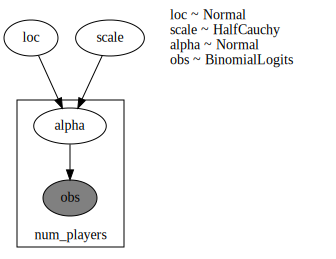

In [11]:
def partially_pooled_with_logit(at_bats, hits):
    r"""
    Number of hits has a Binomial distribution with a logit link function.
    The logits $\alpha$ for each player is normally distributed with the
    mean and scale parameters sharing a common prior.

    Parameters
    ----------
    at_bats: Number of at bats for each player.
    hits: Number of hits for the given at bats.
    
    Returns
    -------
    Number of hits predicted by the model.
    """
    num_players = at_bats.shape[0]
    loc = numpyro.sample("loc", dist.Normal(-1, 1))
    scale = numpyro.sample("scale", dist.HalfCauchy(1))
    with numpyro.plate("num_players", num_players):
        alpha = numpyro.sample("alpha", dist.Normal(loc, scale))
        return numpyro.sample("obs", dist.Binomial(at_bats, logits=alpha), obs=hits)
    
numpyro.render_model(partially_pooled_with_logit, (at_bats, hits), render_distributions=True)

In [12]:
model = partially_pooled_with_logit

# Run the inference
mcmc = run_inference(model, at_bats, hits)
mcmc.print_summary()

/tmp/ipykernel_155878/457514835.py:18: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=100, num_samples=200, num_chains=4)
sample: 100%|██████████| 300/300 [00:00<00:00, 7706.67it/s, 15 steps of size 3.74e-01. acc. prob=0.66]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]     -0.88      0.22     -0.92     -1.24     -0.52     63.71      1.07
  alpha[1]     -0.91      0.20     -0.93     -1.22     -0.58     54.24      1.08
  alpha[2]     -0.92      0.20     -0.94     -1.21     -0.57     90.34      1.07
  alpha[3]     -0.96      0.19     -0.97     -1.27     -0.64    157.64      1.03
  alpha[4]     -0.99      0.18     -0.99     -1.27     -0.71    139.49      1.03
  alpha[5]     -0.97      0.19     -0.99     -1.27     -0.68    165.33      1.03
  alpha[6]     -1.00      0.17     -1.01     -1.26     -0.70    180.63      1.03
  alpha[7]     -1.03      0.18     -1.03     -1.30     -0.74    365.07      1.01
  alpha[8]     -1.07      0.18     -1.06     -1.36     -0.80    443.86      1.00
  alpha[9]     -1.05      0.18     -1.05     -1.32     -0.77    441.95      1.00
 alpha[10]     -1.08      0.18     -1.08     -1.37     -0.78    454.92      1.00
 alpha[11]     -1.09      0